# In this Project we will use soil humidity data collected from an Arduino Uno to predict future values using a SARIMA model 

In [47]:
#import libraries 
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
rcParams['figure.figsize']=10,6

In [2]:
#load the data
df= pd.read_csv('Soil_humidity.csv',parse_dates=['Minute'],infer_datetime_format=True)
#index the dataet using months
indf=df.set_index(['Minute'])

The plot appears to  be stationary and picks up a trend overtime.

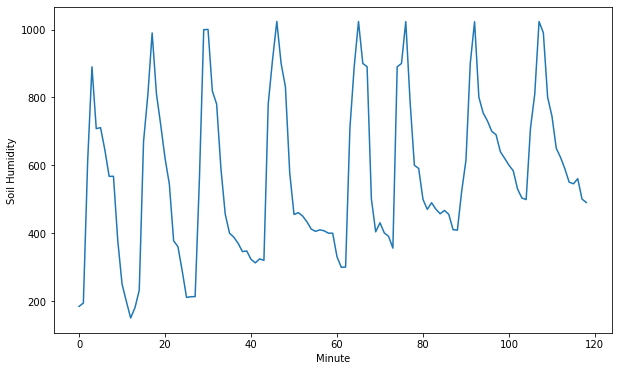

In [3]:
plt.xlabel('Minute')
plt.ylabel('Soil Humidity')
plt.plot(df.Humidity)

In [4]:
indf.describe()

,Humidity
count,119.000000
mean,570.979845
std,230.468795
min,150.139871
25%,400.459003
50%,545.545016
75%,737.862540
max,1023.887460


In [5]:
passing_data=adfuller(df['Humidity'])

In [6]:
def adf_test(Humidity):
    result=adfuller(Humidity)
    labels = ['Test parameters', 'p-value','#Lags Used','Dataset observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Dataset is stationary")
    else:
        print("Dataset is non-stationary ")

In [7]:
adf_test(df['Humidity'])

Test parameters : -6.476186995178725
p-value : 1.3293753958618287e-08
#Lags Used : 2
Dataset observations : 116
Dataset is stationary


In [8]:
train=indf.Humidity[:int (len(indf.Humidity)*0.75)] #split dataset into 75/25%
test=indf.Humidity[int(len(indf.Humidity)*0.75):]

The ACF plot indicates that there is seasonality in the data and there is tail off on lag 2 which means that data from 2 lags have the most importance, and there is also seasonality, so q=2 will be chosen as the idea value for MA(q).

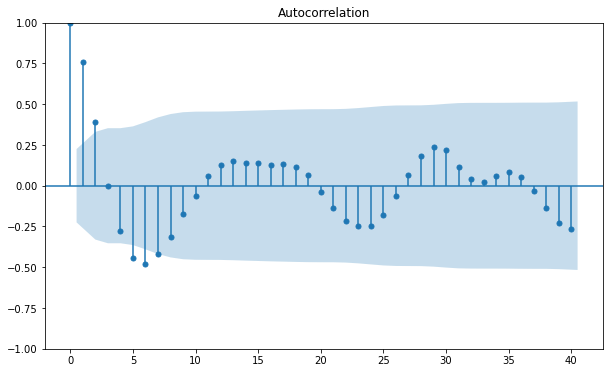

In [53]:
fig = sm.graphics.tsa.plot_acf(train.iloc[13:],lags=40)

The PACF plot indicates a tail off at lag 3 so p=3 for AR, we also see a direct influence from points at 30

C:\Users\TT\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


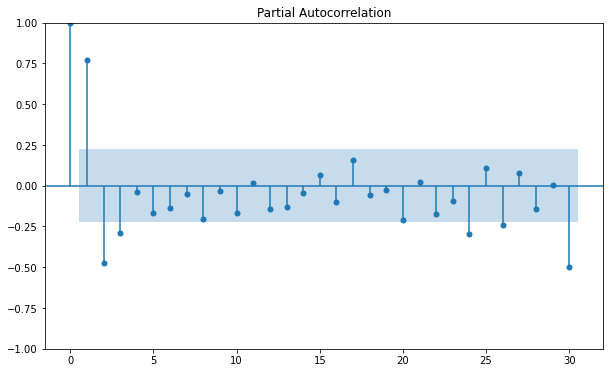

In [54]:
fig1 = sm.graphics.tsa.plot_pacf(train.iloc[13:],lags=30)

# For a first try,  Let's fit an Arima model of order p=2, q=3, d=0

In [34]:
model=ARIMA(df['Humidity'],order=(2,0,3))

In [35]:
arima_model=model.fit()

<AxesSubplot:>

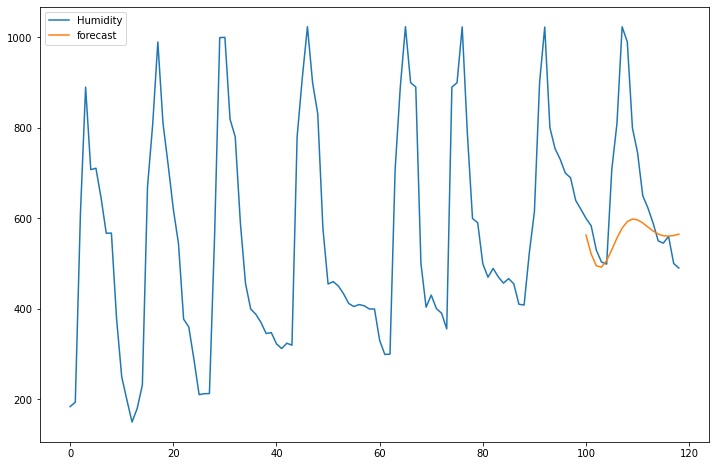

In [36]:
df['forecast']=arima_model.predict(start=100,end=120,dynamic=True)
df[['Humidity','forecast']].plot(figsize=(12,8))

A stepwise auto arima shows that the best fit of an arma would be  ARIMA(1,1,0) with an AIC of 1138

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1142.409, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1146.923, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1140.419, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1141.944, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1144.946, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1142.392, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1143.366, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1138.431, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1140.405, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1140.422, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1139.958, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1141.378, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.786 seconds
                               SARIMAX Results                                
Dep. Vari

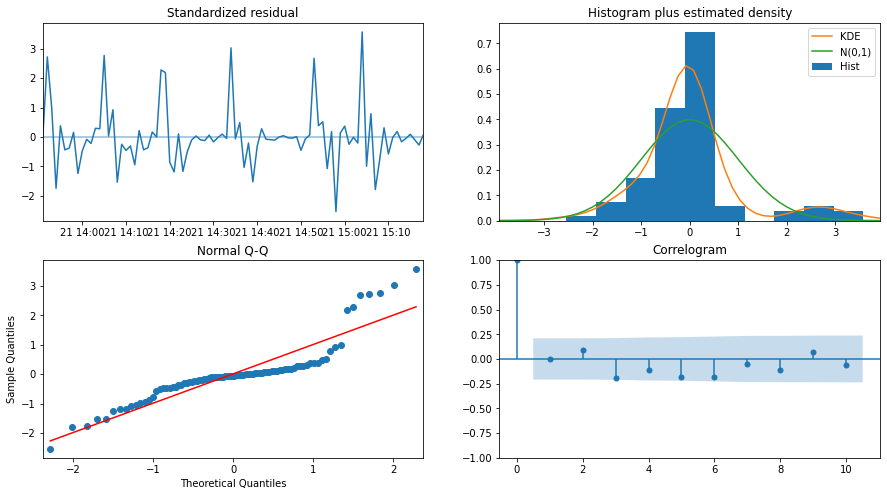

In [14]:
model_autoARIMA=auto_arima(train, start_p=1,start_q=1,max_p=4,max_q=4,test='adf',m=1, d=1, seasonal=False, trace=True, D=0, error_action='ignore',suppress_warning=True,stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

The forecast for this model was pretty bad, maybe because of the few number of examples in the training data.

In [37]:
def forecasts(model,actual):
    fc, conf=model.predict(n_periods=len(actual),return_conf_int=True)
    fc_series=pd.Series(fc, index=test.index)
    lower_bound=pd.Series(conf[:,0],index=actual.index)
    upper_bound=pd.Series(conf[:,1],index=actual.index)
    #plot
    plt.plot(indf.Humidity)
    plt.plot(actual, color='orange', label='actual')
    plt.plot(fc_series,color='green', label='Forecasts')
    plt.fill_between(lower_bound.index, lower_bound, upper_bound, color='k',alpha=.15)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Humidity')
    plt.title("Forecast of Humidity")

    plt.show()


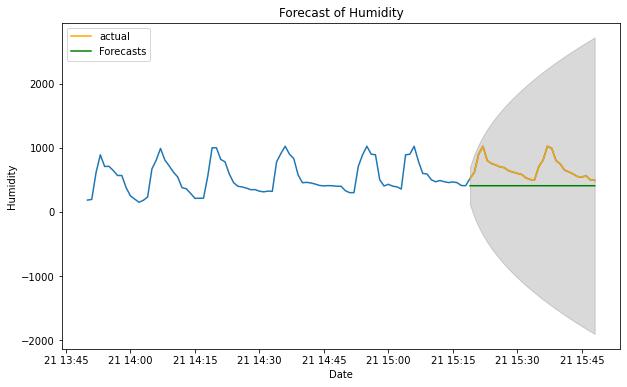

In [38]:
forecasts(model_autoARIMA,test)

In [39]:
def measure_performance(forecast,actual):
    #mean error
    ME= np.mean(forecast-actual)
    #Mean Absolute Percentage error
    MAPE=np.mean(np.abs(forecast-test)/np.abs(actual))
    #mean percentage error
    MPE=np.mean((forecast-actual)/actual)
    # Lag 1 Autocorrelationn Error
    acf_error=acf(forecast-actual)[1]
    #mean squared error
    MSE=mean_squared_error(actual,forecast)
    #Correlation
    corr=np.corrcoef(forecast, actual)[0,1]
    df_performance=pd.Series([ME,MAPE,MPE,corr,acf_error,MSE],index=['Mean Error','Mean Absolute Percentage Error','Mean Percentage Error','Correlation','Lag 1 Autocorrelationn Error','Mean Squared Error'])
    return df_performance

In [40]:
fc, conf=model_autoARIMA.predict(n_periods=len(test),return_conf_int=True)
forecastArima_series=pd.Series(fc, index=test.index)
measure_performance(forecastArima_series,test)

Mean Error                         -268.691731
Mean Absolute Percentage Error        0.368698
Mean Percentage Error                -0.368698
Correlation                          -0.165560
Lag 1 Autocorrelationn Error          0.730455
Mean Squared Error                95708.190292
dtype: float64

#Since our data is seasonal a Sarima model will solve the issues we were facing.

In [19]:
#lets build SARIMA model
model_Sarima=auto_arima(train, start_p=1,start_q=1,max_p=4,max_q=4,test='adf',m=12, d=None, seasonal=True, trace=True,start_P=1, D=1, error_action='ignore',suppress_warning=True,stepwise=True)
forecast_sm,conf=model_Sarima.predict(n_periods=len(test),return_conf_int=True)
sm_forecast=pd.Series(forecast_sm, index=test.index)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1101.862, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1033.505, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1099.868, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1038.660, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1019.128, Time=0.60 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1086.832, Time=0.30 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1012.182, Time=0.77 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1019.765, Time=0.35 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1005.4

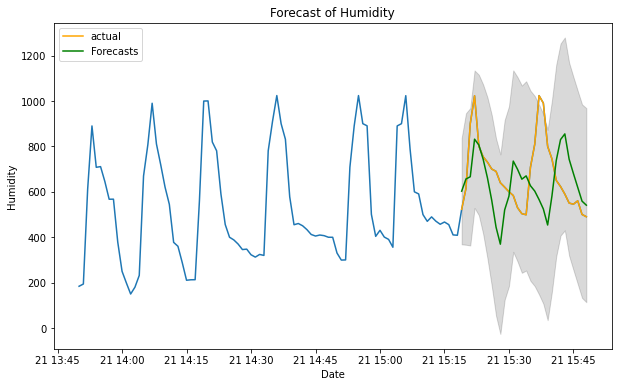

In [20]:
forecasts(model_Sarima,test)

In [21]:
#model accuracy
measure_performance(sm_forecast,test)

Mean Error                          -39.184704
Mean Absolute Percentage Error        0.231803
Mean Percentage Error                -0.012591
Correlation                          -0.020388
Lag 1 Autocorrelationn Error          0.774324
Mean Squared Error                39315.846668
dtype: float64

# Let's tweak some of the parameters

Because of the few training examples, 

I know that I am watering my plant every 15 mins so s=15, and a D=2 and Q=2 was needed to accurately predict from minute 100 till 117.

In [82]:
model=sm.tsa.statespace.SARIMAX(df['Humidity'],order=(2, 0, 1),seasonal_order=(2,2,2,15))

In [83]:
sarima_model=model.fit()

C:\Users\TT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<AxesSubplot:>

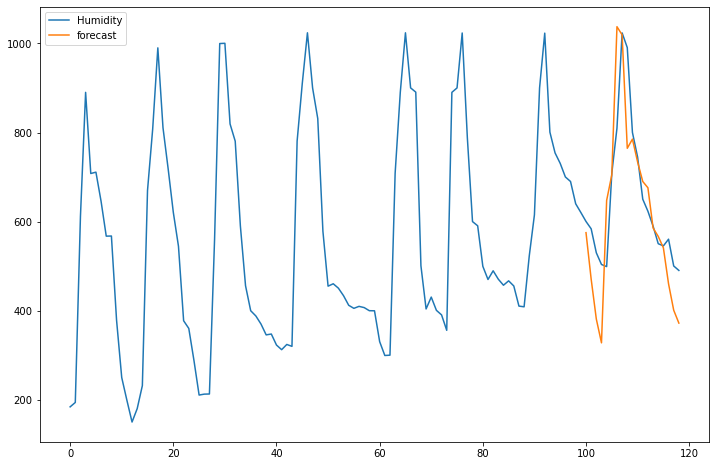

In [86]:
df['forecast']=sarima_model.predict(start=100,end=120,dynamic=True)
df[['Humidity','forecast']].plot(figsize=(12,8))

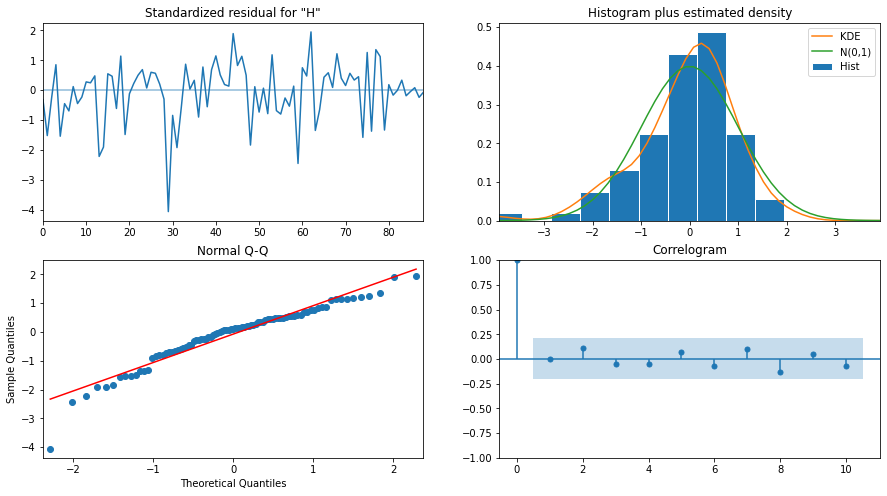

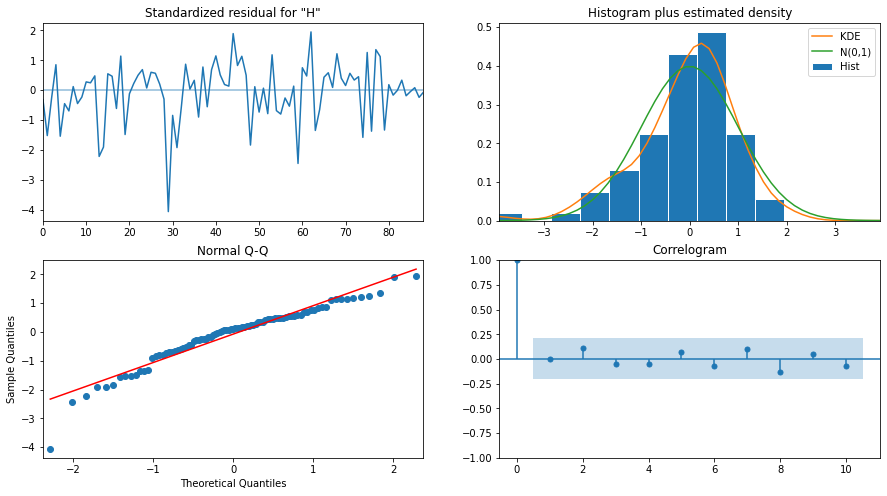

In [87]:
sarima_model.plot_diagnostics(figsize=(15,8))